<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idősorok előrebecslése mély tanulással

Mottó: a jóslás nehéz műfaj, főleg a jövőre vonatkozó

## Adatok előkészítése

A KSH oldaláról letölthető, 2015 napjainkig tartó halálozási adatokat fogjuk használni. Az adatok heti bontásban és több korcsoportra állnak rendelkezésre. Mi csak a heti összesítést fogjuk használni, egyváltozós adatsorként.

Az adatokat egy pandas adatkeretbe töltjük be.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import zeros, mean, array
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, InputLayer, Input
from keras.models import Model

# adatok letöltése
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/weekly_death.csv
df = pd.read_csv('weekly_death.csv', parse_dates=['start', 'end'])
df[['start', 'end', 'all_total']].head()

,start,end,all_total
0,2014-12-29,2015-01-04,2800
1,2015-01-05,2015-01-11,3005
2,2015-01-12,2015-01-18,2900
3,2015-01-19,2015-01-25,3005
4,2015-01-26,2015-02-01,3067


Nézzük meg az adatok időbeli változásátt!

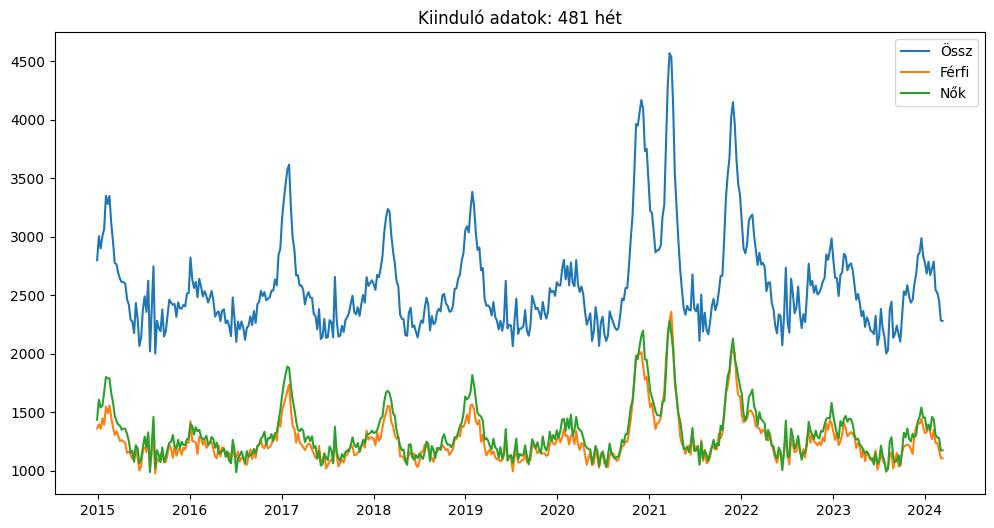

In [2]:
plt.figure(figsize=(12,6))
plt.plot(df['start'], df['all_total'], label='Össz')
plt.plot(df['start'], df['man_total'], label='Férfi')
plt.plot(df['start'], df['woman_total'], label='Nők')
plt.legend()
_ = plt.title(f'Kiinduló adatok: {df.shape[0]} hét')

Kialakítjuk a rövid, *n_steps* hosszúságú adatsorokat a modellek tanításához.

In [3]:
# az egyváltozós időadatok átalakítás n_steps hosszúságú mintákra
def split_sequence(seq, n_steps):
	sequence = seq.to_numpy()
	n = sequence.shape[0]
	X = zeros((n - n_steps, n_steps))
	y = sequence[n_steps:]
	for i in range(n-n_steps):
		X[i] = sequence[i:i+n_steps]
	return X, y

# define input sequence
raw_seq = df['all_total']
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# split train and test data
X_train = X[:468]
y_train = y[:468]
X_test = X[468:]
y_test = y[468:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((468, 3, 1), (468,), (10, 3, 1), (10,))

## 1D konvolúciós neurális hálózat

Egy autoregresszív módszert használunk az adatok rövidtávú előrebecsléséhez.

In [4]:
# modell definíció
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
print(model.summary())
# modell tanítása
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3493 (13.64 KB)
Trainable params: 3493 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

Hasonlítsuk össze az ismert értékeket a modellből becsült adatokkal.

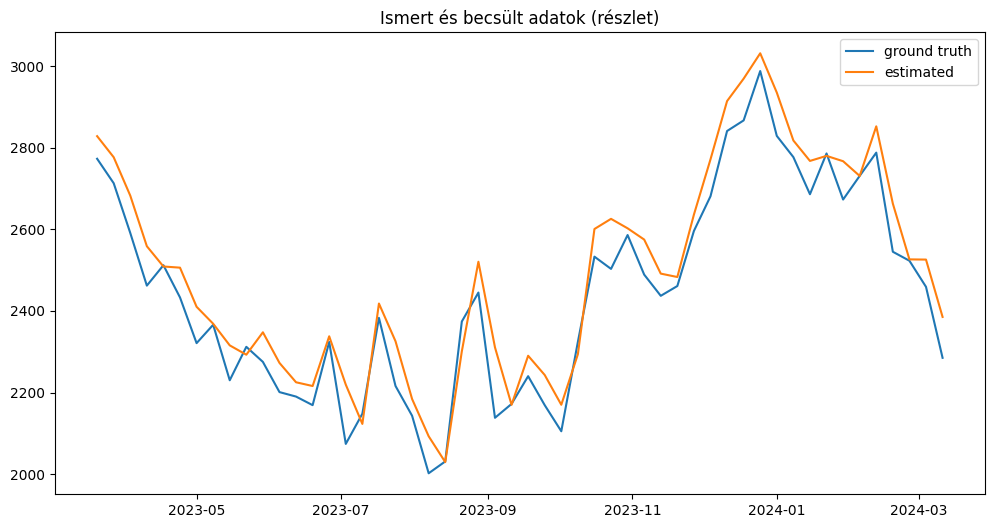

In [5]:
# predict values from model
y_pred = model.predict(X, verbose=0)
plt.figure(figsize=(12,6))
plt.plot(df["start"][-52:], y[-53:-1], label='ground truth')   # TODO one week shift!
plt.plot(df["start"][-52:], y_pred[-52:], label='estimated')
plt.legend()
_ = plt.title('Ismert és becsült adatok (részlet)')

Becslés a teszt adatokra.

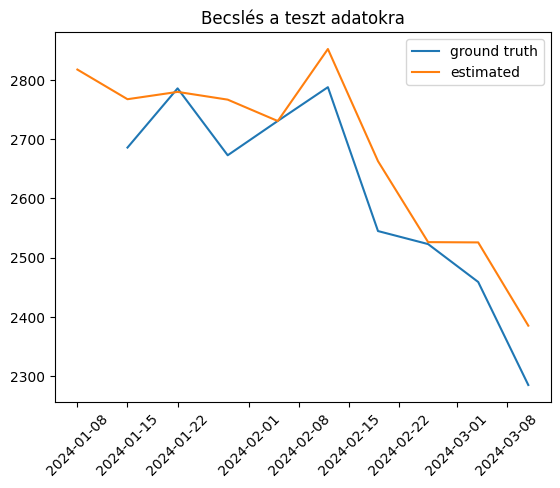

In [7]:
# make estimation for 2024 data
plt.plot(df['start'][-y_test.shape[0]+1:], y_test[:-1], label='ground truth')
plt.plot(df['start'][-y_test.shape[0]:], y_pred[-y_test.shape[0]:], label='estimated')
plt.xticks(rotation=45)
plt.legend()
_ = plt.title('Becslés a teszt adatokra')

Néhány statisztikai adat a modell becsléséről.

In [8]:
# mean absolute percentage error MAPE
print(f"MAPE  all: {mean_absolute_percentage_error(y[:-1], y_pred[1:]):5.1%}")
print(f"MAPE test: {mean_absolute_percentage_error(y[-y_test.shape[0]-1:-1], y_pred[-y_test.shape[0]:]):5.1%}")
# root mean square error
print(f"RMS   all: {mean_squared_error(y[:-1], y_pred[1:])**0.5:.1f}")
print(f"RMS  test: {mean_squared_error(y[-y_test.shape[0]-1:-1], y_pred[-y_test.shape[0]:])**0.5:.1f}")

MAPE  all:  2.6%
MAPE test:  2.2%
RMS   all: 82.9
RMS  test: 70.6


Becsüljük egy következő értéket.

In [24]:
X_new = X_test[-1]
X_new = X_new.reshape(1, 3, 1)
y_new_pred = model.predict(X_new, verbose=0)
print(f"Becslés 2024.03.18-25 hétre: {int(y_new_pred[0, 0])}")

Becslés 2024.03.18-25 hétre: 2385


## Recurrent Neural Network (RNN)

Az RNN Long Short-Term Memory (LSTM) típusú neurális hálózatot használ.

In [10]:
inputs = Input(shape=(n_steps, n_features))
lstm = LSTM(50, activation="relu")(inputs)
outputs = Dense(1)(lstm)

lstm_model = Model(inputs, outputs)
lstm_model.compile(optimizer='adam', loss='mse')
print(lstm_model.summary())

hist =lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, verbose=0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


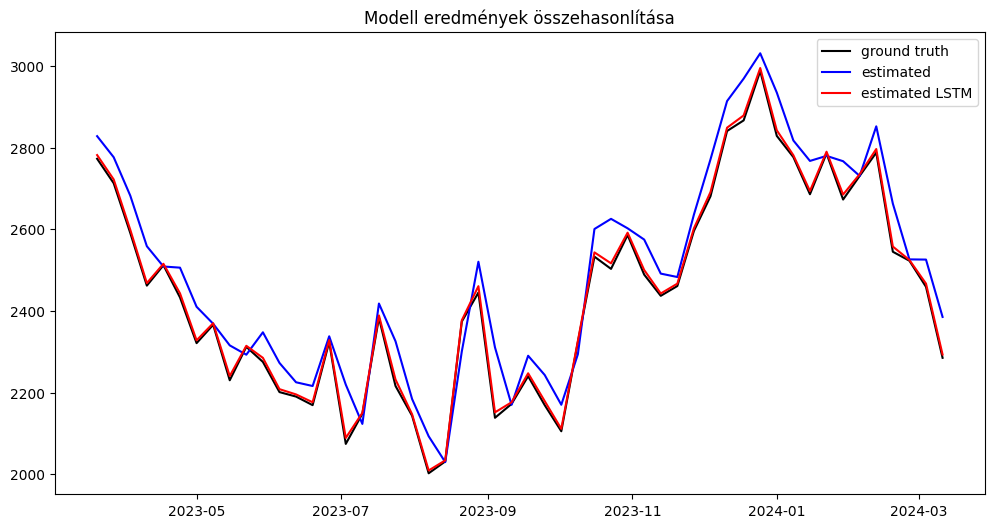

In [11]:
# predict values from model
y_lstm_pred = lstm_model.predict(X, verbose=0)
plt.figure(figsize=(12,6))
plt.plot(df["start"][-52:], y[-53:-1], c='black', label='ground truth')   # TODO one week shift!
plt.plot(df["start"][-52:], y_pred[-52:], c='blue', label='estimated')
plt.plot(df["start"][-52:], y_lstm_pred[-52:], c='red', label='estimated LSTM')
plt.legend()
_ = plt.title('Modell eredmények összehasonlítása')

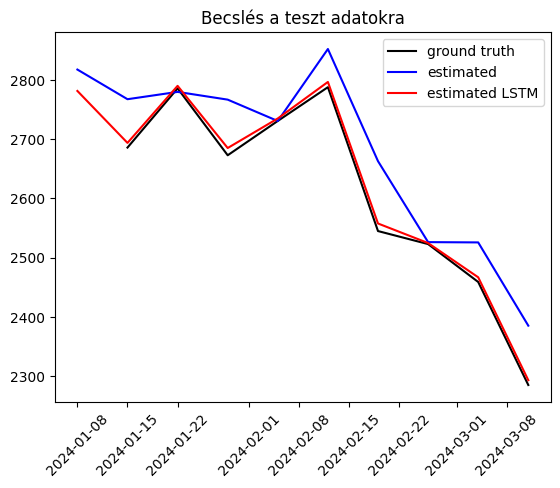

In [13]:
plt.plot(df['start'][-y_test.shape[0]+1:], y_test[:-1], c='black', label='ground truth')
plt.plot(df['start'][-y_test.shape[0]:], y_pred[-y_test.shape[0]:], c='blue', label='estimated')
plt.plot(df['start'][-y_test.shape[0]:], y_lstm_pred[-y_test.shape[0]:], c='red', label='estimated LSTM')
plt.xticks(rotation=45)
plt.legend()
_ = plt.title('Becslés a teszt adatokra')

In [14]:
print("            CNN      RNN")
print(f"MAPE  all: {mean_absolute_percentage_error(y[:-1], y_pred[1:]):5.1%}", end="")
print(f"    {mean_absolute_percentage_error(y[:-1], y_lstm_pred[1:]):5.1%}")
print(f"MAPE test: {mean_absolute_percentage_error(y[-y_test.shape[0]-1:-1], y_pred[-y_test.shape[0]:]):5.1%}", end="")
print(f"    {mean_absolute_percentage_error(y[-y_test.shape[0]-1:-1], y_lstm_pred[-y_test.shape[0]:]):5.1%}")
# root mean square error
print(f"RMS   all: {mean_squared_error(y[:-1], y_pred[1:])**0.5:.1f}", end="")
print(f"     {mean_squared_error(y[:-1], y_lstm_pred[1:])**0.5:.1f}")
print(f"RMS  test: {mean_squared_error(y[-y_test.shape[0]-1:-1], y_pred[-y_test.shape[0]:])**0.5:.1f}", end="")
print(f"     {mean_squared_error(y[-y_test.shape[0]-1:-1], y_lstm_pred[-y_test.shape[0]:])**0.5:.1f}")

            CNN      RNN
MAPE  all:  2.6%     0.3%
MAPE test:  2.2%     0.3%
RMS   all: 82.9     10.3
RMS  test: 70.6     8.0


In [23]:
# predict for future
X_new = X_test[-1]
X_new = X_new.reshape(1, 3, 1)
y_new_lstm_pred = lstm_model.predict(X_new, verbose=0)
print(f"Becslés 2024.03.18-25 hétre: {int(y_new_lstm_pred[0, 0])}")

Becslés 2024.03.18-25 hétre: 2293
